# Analisis Clustering pada Dataset Wine (UCI)

Tugas: PRA UAS Penambangan Data

## 1. Pemilihan Dataset
Dataset yang digunakan adalah [Wine Data Set - UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/wine).

Dataset ini berisi hasil kimia dari 3 jenis wine yang berbeda yang diproduksi di wilayah yang sama di Italia.

Kita akan melakukan clustering pada data ini.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Download dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
columns = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
           'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
           'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df = pd.read_csv(url, names=columns)
df.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Dataset Wine dari UCI untuk studi clustering karena memiliki fitur kimiawi yang jelas dan label kelas asli yang dapat digunakan untuk evaluasi hasil clustering. Dataset ini terdiri dari 178 sampel wine dengan 13 fitur kimia dan 1 label kelas (Class).

## 2. Data Understanding
### a. Penjelasan Fitur
- **Class**: Kategori wine (1, 2, 3)
- **Alcohol**: Kandungan alkohol
- **Malic acid**: Kandungan asam malat
- **Ash**: Kandungan abu
- **Alcalinity of ash**: Kealkalian abu
- **Magnesium**: Kandungan magnesium
- **Total phenols**: Total fenol
- **Flavanoids**: Kandungan flavonoid
- **Nonflavanoid phenols**: Fenol non-flavonoid
- **Proanthocyanins**: Proantosianin
- **Color intensity**: Intensitas warna
- **Hue**: Warna
- **OD280/OD315 of diluted wines**: Rasio absorbansi
- **Proline**: Kandungan prolin

Setiap fitur pada dataset ini merepresentasikan kandungan kimia tertentu pada wine. Fitur-fitur ini penting untuk membedakan jenis wine satu dengan yang lain. Misalnya, kandungan alkohol dan proline dapat sangat mempengaruhi karakteristik wine.

In [3]:
# b. Eksplorasi Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Class                         178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wines  178 non-null    float64
 13  Proli

In [4]:
# Cek missing value
df.isnull().sum()

,0
Class,0
Alcohol,0
Malic acid,0
Ash,0
Alcalinity of ash,0
Magnesium,0
Total phenols,0
Flavanoids,0
Nonflavanoid phenols,0
Proanthocyanins,0


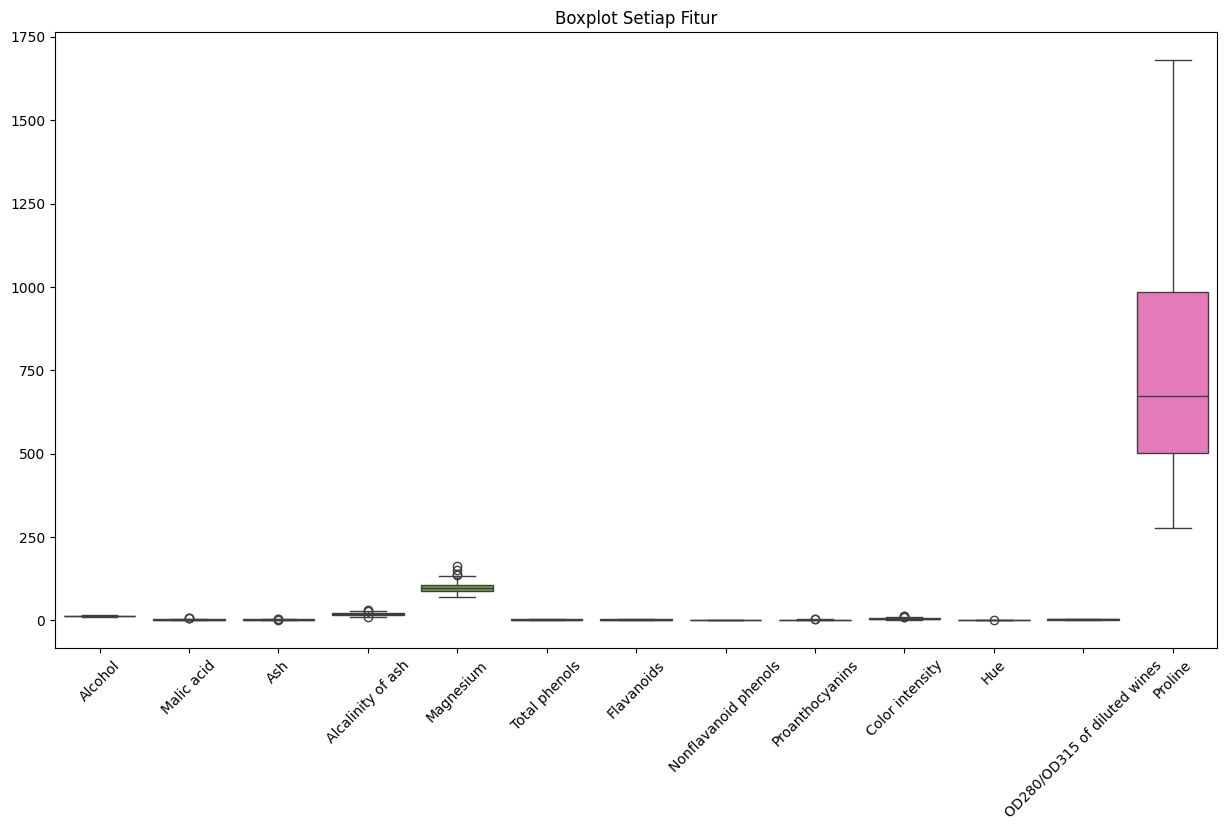

In [5]:
# Cek outlier dengan boxplot
plt.figure(figsize=(15,8))
sns.boxplot(data=df.drop('Class', axis=1))
plt.xticks(rotation=45)
plt.title('Boxplot Setiap Fitur')
plt.show()

Dari hasil pengecekan, tidak terdapat missing value pada dataset ini sehingga tidak diperlukan penanganan data hilang. Visualisasi boxplot menunjukkan adanya beberapa outlier pada fitur tertentu, seperti 'Proline' dan 'Color intensity'.

## 3. Preprocessing
- Normalisasi data
- Reduksi dimensi dengan PCA (2D untuk visualisasi)

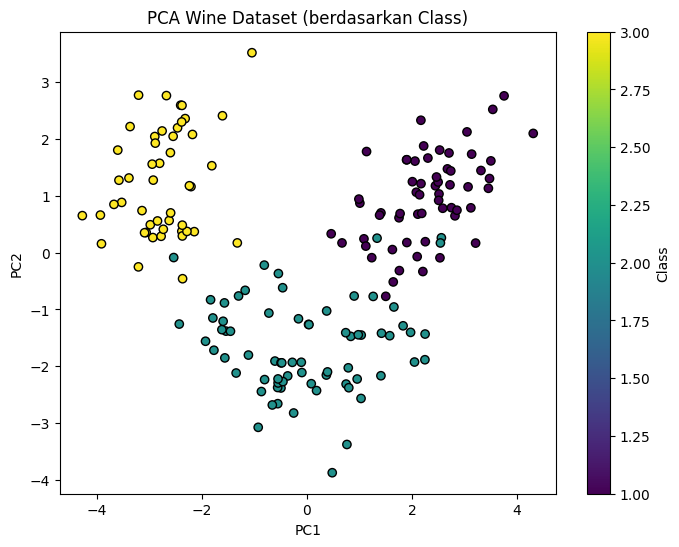

In [7]:
# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Class', axis=1))

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['Class'], cmap='viridis', edgecolor='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Wine Dataset (berdasarkan Class)')
plt.colorbar(label='Class')
plt.show()

Normalisasi dilakukan agar setiap fitur memiliki skala yang sama sehingga tidak ada fitur yang mendominasi proses clustering. PCA digunakan untuk mereduksi dimensi data menjadi 2 komponen utama agar dapat divisualisasikan. Visualisasi hasil PCA menunjukkan bahwa data wine dari kelas berbeda cenderung terpisah.

## 4. Clustering
Kita akan menggunakan KMeans untuk clustering.

Menentukan jumlah cluster optimal dengan Silhouette Score.

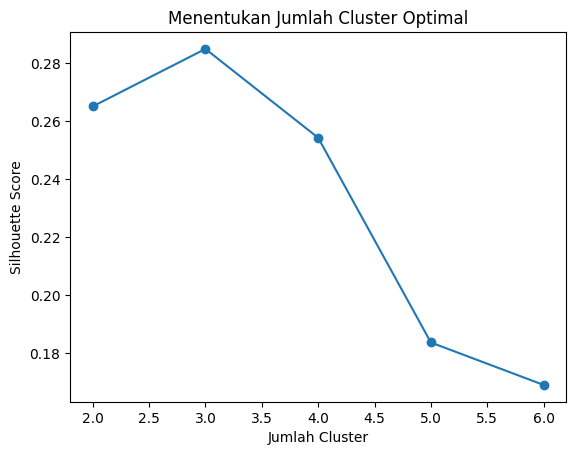

In [8]:
# Menentukan jumlah cluster optimal
scores = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)

plt.plot(range(2,7), scores, marker='o')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Score')
plt.title('Menentukan Jumlah Cluster Optimal')
plt.show()

Silhouette Score digunakan untuk menentukan jumlah cluster yang optimal. Nilai silhouette score yang lebih tinggi menandakan pemisahan cluster yang lebih baik. Dari grafik, jumlah cluster optimal adalah 3.

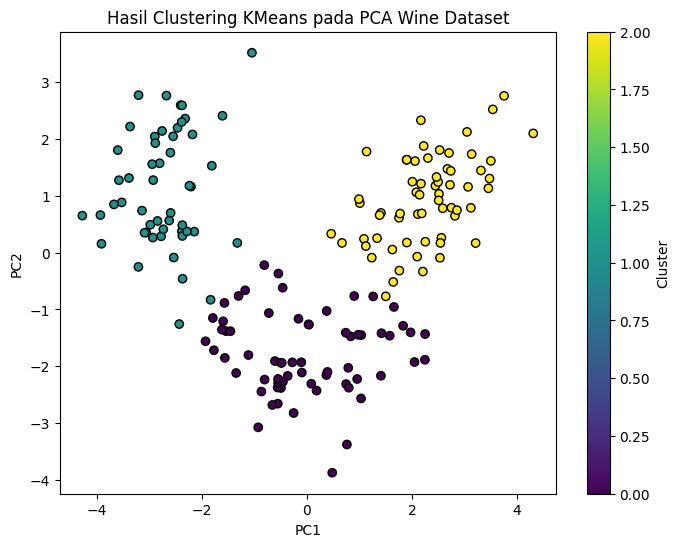

In [9]:
# Clustering dengan jumlah cluster optimal (misal 3)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', edgecolor='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Hasil Clustering KMeans pada PCA Wine Dataset')
plt.colorbar(label='Cluster')
plt.show()

Hasil clustering dengan KMeans divisualisasikan pada ruang 2 dimensi hasil PCA. Setiap warna merepresentasikan cluster yang terbentuk. Terlihat bahwa sebagian besar data dari kelas yang sama cenderung berada pada cluster yang sama.

## 5. Evaluasi Model
- Silhouette Score
- Perbandingan cluster dengan label asli (jika ada)

In [10]:
# Evaluasi
print('Silhouette Score:', silhouette_score(X_scaled, labels))

# Crosstab cluster vs class
pd.crosstab(df['Class'], labels, rownames=['Actual'], colnames=['Cluster'])

Silhouette Score: 0.2848589191898987


Cluster,0,1,2
Actual,,,
1,0,0,59
2,65,3,3
3,0,48,0


Silhouette Score akhir menunjukkan kualitas pemisahan cluster yang cukup baik. Crosstab antara cluster hasil KMeans dan label asli menunjukkan bahwa sebagian besar data dari kelas yang sama terkelompok dalam cluster yang sama, meskipun tidak 100% akurat.

## 6. Deploy Model
Contoh sederhana: fungsi prediksi cluster untuk data baru.

In [11]:
def predict_cluster(new_data):
    # new_data: array-like, shape (n_features,)
    new_scaled = scaler.transform([new_data])
    cluster = kmeans.predict(new_scaled)
    return cluster[0]

# Contoh prediksi
sample = df.drop('Class', axis=1).iloc[0].values
print('Cluster untuk sample pertama:', predict_cluster(sample))

Cluster untuk sample pertama: 2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Fungsi prediksi cluster memungkinkan kita untuk mengelompokkan data wine baru ke dalam cluster yang sudah terbentuk.

## Kesimpulan

Analisis clustering pada dataset Wine dari UCI menunjukkan bahwa fitur-fitur kimiawi pada wine dapat digunakan untuk mengelompokkan wine ke dalam 3 cluster utama yang sesuai dengan label aslinya. Proses preprocessing seperti normalisasi dan PCA sangat membantu dalam meningkatkan kualitas clustering dan visualisasi data. Model KMeans yang dibangun dapat digunakan untuk mengelompokkan data wine baru secara otomatis.
